In [1]:
!git clone https://github.com/icomse/5th_workshop_MachineLearning.git
import os
os.chdir('5th_workshop_MachineLearning/data')
data_dir = os.getcwd()

Cloning into '5th_workshop_MachineLearning'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 203 (delta 34), reused 26 (delta 14), pack-reused 156
Receiving objects: 100% (203/203), 99.50 MiB | 19.41 MiB/s, done.
Resolving deltas: 100% (91/91), done.
Updating files: 100% (45/45), done.


In [2]:
import torch
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
from ast import literal_eval
from sklearn.model_selection import train_test_split, GridSearchCV
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

torch.manual_seed(44)

plt.style.use(os.path.join(data_dir, 'configs', 'plot_style.mplstyle'))

In [3]:
!pip install matminer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 648.9/648.9 kB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.3/515.3 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.7/283.7 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.3/154.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 42.2 MB/s eta 0:00:00


In [4]:
from matminer.datasets import load_dataset
from matminer.featurizers.composition import ElementFraction
from pymatgen.core.composition import Composition


# Let's play with some materials science data using `matminer`

In [5]:
df = load_dataset('matbench_glass')
df.head()

Fetching matbench_glass.json.gz from https://ml.materialsproject.org/projects/matbench_glass.json.gz to /usr/local/lib/python3.10/dist-packages/matminer/datasets/matbench_glass.json.gz


Fetching https://ml.materialsproject.org/projects/matbench_glass.json.gz in MB: 0.040959999999999996MB [00:00, 19.47MB/s]     


,composition,gfa
0,Al,False
1,Al(NiB)2,True
2,Al10Co21B19,True
3,Al10Co23B17,True
4,Al10Co27B13,True


In [6]:
gfas = df.gfa.values
df['gfa'] = [1 if v == True else 0 for v in gfas]
df.head()

,composition,gfa
0,Al,0
1,Al(NiB)2,1
2,Al10Co21B19,1
3,Al10Co23B17,1
4,Al10Co27B13,1


In [7]:
df.composition.value_counts()

Al                 1
Si16.5Ag6Pd77.5    1
Si11Ni78B11        1
Si10Ni73B17        1
Si10Ge7Pd83        1
                  ..
Fe79(Cu5B2)3       1
Fe79(BP6)3         1
Fe79(BP2)7         1
Fe79(B6P)3         1
ZrVNi2             1
Name: composition, Length: 5680, dtype: int64

In [8]:
all_formulas = df.composition.values
elfrac = ElementFraction()
df['elfrac'] = [elfrac.featurize(Composition(formula)) for formula in all_formulas]

In [9]:
X = np.concatenate(df['elfrac'].values).reshape(len(df), len(df.elfrac.values[0]))
y = df['gfa'].values

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# **Hands-on**: Use some shallow ML models of your choosing to see how well you can predict whether a material will be a glass based on its chemical composition

## Guidelines:
- validation scores matter, not training scores
- compare to [the leaderboard at matbench](https://matbench.materialsproject.org/Leaderboards%20Per-Task/matbench_v0.1_matbench_glass/)


In [11]:
# your code here

In [12]:
# STOP!

# OK, back to `torch`

- we need our X and y to be torch.tensor objects
- it's convenient to link together X and y

In [13]:
class JointDataSet():

    """
    Link together a feature matrix and a target array
    """

    def __init__(self, X, y):
        """
        Args:
            X (2d np array) - columns are features, rows are samples
            y (1d np array) - values are the target property for each sample
        """
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        """
        len(JointdataSet) returns len(X)
        """
        return len(self.X)

    def __getitem__(self, idx):
        """
        Slicing JointDataSet returns (X[sample], y[sample])
        """
        return self.X[idx], self.y[idx]

In [14]:
joint_dataset = JointDataSet(X_train, y_train)
print(joint_dataset.X.shape)
print(joint_dataset.y.shape)

torch.Size([4544, 103])
torch.Size([4544])


In [15]:
joint_dataset[3]

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3600, 0.0000,
         0.5400, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.1000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000]),
 tensor(1.))

# The joint dataset links all of our training data together. But we also want to load one batch at a time for training

In [16]:
def load_data(X, y, val_size=0.2, random_n=None, batch_size=1, shuffle=True, drop_last=True):
    """
    Args:
        X (2d np array) - columns are features, rows are samples
        y (1d np array) - values are the target property for each sample
        val_size (float) - fraction of data to reserve for validation
        random_n (int or None) - if int, use only every random_nth sample from X and y (if None, use all of X and y)
        batch_size (int) - size of each batch for training
        shuffle (bool) - shuffle samples in X, y

    Returns:
        {'train' : PyTorch DataLoader object for training set, split into batches of size batch_size,
         'val' : PyTorch DataLoader object for validation set, held in one single batch}

    """

    # split our training set into training and validation
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, random_state=44)

    # slice our training set for de-bugging
    if random_n:
        X_train = X_train[::random_n, :]
        y_train = y_train[::random_n]

    # link X and y for training
    joint_dataset_train = JointDataSet(X_train, y_train)

    # link X and y for validation
    joint_dataset_val = JointDataSet(X_val, y_val)

    # return the "loaded" data
    return {'train' : DataLoader(dataset=joint_dataset_train, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last),
            'val' : DataLoader(dataset=joint_dataset_val, batch_size = len(joint_dataset_val), shuffle=shuffle, drop_last=drop_last)}


In [17]:
# fraction for validation
val_size = 0.2

# use every nth point
random_n = 1

# how many training points per optimization batch
batch_size = 8

# load training and validation data
data_loader = load_data(X_train, y_train, val_size=val_size, random_n=random_n, batch_size=batch_size)

# Now our data is made to be enumerated

In [18]:
for i, batch in enumerate(data_loader['train'], 1):
    print('x', batch[0].size(),
          'y', batch[1].size())
    break

x torch.Size([8, 103]) y torch.Size([8])


In [19]:
for i, batch in enumerate(data_loader['val'], 1):
    print('x', batch[0].size(),
          'y', batch[1].size())
    break

x torch.Size([909, 103]) y torch.Size([909])


# We have our data, now we need to build our model (in a slightly more flexible way than before)

In [20]:
def construct_model(X_train, hidden_layer_sizes, output_size, act_fn, dropout, norm):
    """
    Args:
        X_train (nd np array):
          feature matrix (only used to grab number of input features)

        hidden_layer_sizes (list of ints) :
          length of the list is number of hidden layers; value at each index is number of neurons in that layer

        output_size (int) :
          length of final output from NN

        act_fn (nn.module) :
          activation function to use after each fully connected layer

        dropout (float or False) :
          if float, % of neurons to drop

        norm (bool) :
          True to BatchNorm all layers but the last one

    Returns:
        nn.module with specified architecture

    """

    input_size = X_train.shape[1] # how many features go into the first layer

    # initialize a sequence of layers
    model = torch.nn.Sequential()

    # add layers
    ## general flow: linear + activation --> linear + activation --> ...
    for i in range(len(hidden_layer_sizes)):

        if norm:
            model.add_module('norm%s' % str(i+1), torch.nn.BatchNorm1d(input_size if i == 0 else hidden_layer_sizes[i-1]))

        if i == 0:
            model.add_module('fc%s' % str(i+1), torch.nn.Linear(input_size, hidden_layer_sizes[i]))
            model.add_module('relu1', act_fn)
        else:
            model.add_module('fc%s' % str(i+1), torch.nn.Linear(hidden_layer_sizes[i-1], hidden_layer_sizes[i]))
            model.add_module('relu%s' % str(i+1), act_fn)

        if dropout:
            model.add_module('drop%s' % str(i+1), torch.nn.Dropout1d(dropout))

    # add our last layer (linear + softmax to get probabilities)
    model.add_module('fc_last', torch.nn.Linear(hidden_layer_sizes[i], output_size))
    model.add_module('soft', torch.nn.Softmax())

    # print the model
    print(model)

    return model

In [21]:
hidden_layer_sizes = [64, 32]
output_size = 2
act_fn = torch.nn.ReLU()
dropout = None
norm = True

model = construct_model(X_train, hidden_layer_sizes, output_size, act_fn, dropout, norm)

Sequential(
  (norm1): BatchNorm1d(103, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=103, out_features=64, bias=True)
  (relu1): ReLU()
  (norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (fc_last): Linear(in_features=32, out_features=2, bias=True)
  (soft): Softmax(dim=None)
)


In [22]:
torch.manual_seed(44)
model(joint_dataset.X[::1000,:])

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([[0.6326, 0.3674],
        [0.5006, 0.4994],
        [0.5815, 0.4185],
        [0.4686, 0.5314],
        [0.5695, 0.4305]], grad_fn=<SoftmaxBackward0>)

# We have our data and a model, now we need to define our loss function


In [23]:
loss_fn = torch.nn.CrossEntropyLoss()

## We can also define a more intuitive scoring metric
- often not the same as the loss function!

In [24]:
def accuracy(actual, pred):

    pred = torch.argmax(pred, dim=1)

    actual = actual.detach().numpy()
    pred = pred.detach().numpy()

    return len([i for i in range(len(actual)) if actual[i] == pred[i]]) / len(actual)

def score(actual, pred, metric='accuracy'):

    if metric == 'accuracy':
        return accuracy(actual, pred)
    else:
      raise NotImpletementedError

# Let's look at a few data points:
- we have 5 observations of class 0 or class 1
- we'll fit our model (for one step) to the element fraction features we made for each of these 5 formulas
- then we'll score our model

In [25]:
actual = joint_dataset.y[:5]
pred = model(joint_dataset.X[:5,:])

print(actual)
print(pred)

print('\n')
print(score(actual, pred))

tensor([1., 1., 1., 1., 1.])
tensor([[0.6438, 0.3562],
        [0.4618, 0.5382],
        [0.4433, 0.5567],
        [0.4933, 0.5067],
        [0.6064, 0.3936]], grad_fn=<SoftmaxBackward0>)


0.6


## And see what our loss is for these 5 observations

In [26]:
loss = loss_fn(pred, actual.type(torch.LongTensor)).item()
print(loss)

0.7265364527702332


# What if we change the first row in `pred` to be `[0.99, 0.01]`
- does our accuracy change?
- does our loss change?

tensor([[0.9900, 0.0100],
        [0.4618, 0.5382],
        [0.4433, 0.5567],
        [0.4933, 0.5067],
        [0.6064, 0.3936]], grad_fn=<CopySlices>)


0.6
0.8168157339096069


# We have data, a model, and a loss function, now we need an optimizer

In [30]:
# learning rate for parameter updates
learning_rate = 1e-3

# regularization to keep our weights small
l2_penalty = 1e-2

# optimization method
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_penalty)

In [31]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.01
)

# Ready to train! (one batch)

In [32]:
def train_one_batch(x_batch, y_batch, X_val, y_val, model, loss_fn, optimizer, metric):
    """
    Args:
        x_batch (np.array) : feature matrix for training batch
        y_batch (np.array) : target array for training batch
        X_val (np.array) : feature matrix for validation
        y_val (np.array) : target array for validation
        model (torch.nn.Module) : neural network
        loss_fn (torch.nn.LossFunction) : loss function for optimization
        optimizer (torch.nn.Optimizer) : optimizer for training
        metric (str) : metric for scoring (only accuracy implemented)

    Returns:
        {'acc' : accuracy on training batch,
         'loss' : loss on training batch,
         'model' : model trained on batch,
         'optimizer' : optimizer after running on batch}

    """

    # make our predictions on this batch of training data
    train_pred = model(x_batch)

    # update our loss function based on these predictions
    if metric in ['accuracy', 'f1']:
        #train_pred = train_pred.type(torch.LongTensor)
        y_batch = y_batch.type(torch.LongTensor)
    elif metric in ['rmse', 'mae']:
        train_pred = torch.flatten(train_pred)
        y_batch = torch.flatten(y_batch)

    loss = loss_fn(train_pred, y_batch)

    # propagate the loss backward
    loss.backward()

    # step our optimizer forward
    optimizer.step()

    # return our optimizer to stage 0
    optimizer.zero_grad()

    # compute the accuracy
    train_acc = score(y_batch, train_pred, metric=metric)

    # compute the value for the loss
    train_loss = loss.item()

    if score in ['accuracy', 'f1']:
        train_loss = train_loss*y_batch.size(0)

    # make predictions on the validation set
    val_pred = model(X_val)
    if metric in ['accuracy', 'f1']:
        y_val = y_val.type(torch.LongTensor)

    # compute accuracy and loss on validation set
    val_acc = score(y_val, val_pred, metric=metric)

    val_loss = loss_fn(val_pred, y_val).item()
    if score in ['accuracy', 'f1']:
        val_loss = val_loss*y_val.size(0) / len(y_val) * y_batch.size(0)

    # also return our model and optimizer to use them for the next batch
    return {'acc' : {'train' : train_acc,
                     'val' : val_acc},
            'loss' : {'train' : train_loss,
                      'val' : val_loss},
            'model' : model,
            'optimizer' : optimizer}

# **Hands on**: Train your model for one epoch

## Guidelines:
- plot training and validation accuracy as a function of batch
- include a relevant baseline in your plot

In [ ]:
# your code here

In [ ]:
# STOP!

# What are you seeing in this plot?

# Now we want to do this over and over (for many epochs)

In [35]:
def train_epochs(num_epochs, data_loader, model, loss_fn, optimizer, metric='accuracy', verbose=0):
    """
    Args:
        num_epochs (int) :
          number of epochs to train for

        data_loader (torch.datasets.DataLoader) :
          data_loader containing X, y in batches

        model (torch.nn.Module) :
          neural network

        loss_fn (torch.nn.LossFunction) :
          loss function

        optimizer (torch.nn.Optimizer) :
          optimizer

        score (str) :
          how to score our model

        verbose (int) :
          how much to print

    Returns:
        {'scores' :
            {epoch (int) :
                {'acc' or 'loss' :
                    {'train' or 'val' :
                        mean score for that batch}
         'model' : model after training,
         'optimizer' : optimizer after training}

    """
    # need our model, loss function, and optimizer to start somewhere
    initial_model = {'model' : model,
                     'loss_fn' : loss_fn,
                     'optimizer' : optimizer}

    # specify sources for data to assess
    data_sources = ['train', 'val']

    # specify metrics to assess model with
    outputs = ['acc', 'loss']

    # initialize a dictionary to store metrics in
    scores = {epoch :
              {output :
                       {src : []
                        for src in data_sources}
               for output in outputs}
              for epoch in range(num_epochs)}

    # get our validation data (the same for each batch in every epoch)
    for X_val, y_val in data_loader['val']:
        print('')

    # loop through epochs (training steps)
        # note: one epoch means we've gone through all batches in our training data
    for epoch in range(num_epochs):
        if verbose > 0:
            print('\n epoch %i' % (epoch+1))
        batch_count = -1

        # loop through all our batches in each epoch
        for x_batch, y_batch in data_loader['train']:
            batch_count += 1

            # if we're on our first batch and first epoch, use our initial model
            if not batch_count and not epoch:
                results = initial_model.copy()

            # otherwise, use the model we optimized on the most recent batch
            model = results['model']
            optimizer = results['optimizer']

            # update the model, optimizer with current batch

            results = train_one_batch(x_batch, y_batch, X_val, y_val, model, loss_fn, optimizer, metric)

            # store the results on this batch
            for output in outputs:
                for src in data_sources:
                    scores[epoch][output][src].append(results[output][src])

        # aggregate the results over all batches for the current epoch
        for output in outputs:
            for src in data_sources:
                score = np.mean(scores[epoch][output][src])
                if verbose > 1:
                    print('%s (%s) : %.3f' % (output, src, score))
                scores[epoch][output][src] = score

    # return the results, the final model, and the final optimizer
    return {'scores' : scores,
            'model' : results['model'],
            'optimizer' : results['optimizer']}

In [36]:
num_epochs = 10
results = train_epochs(num_epochs, data_loader, model, loss_fn, optimizer, metric='accuracy', verbose=0)

In [37]:
results['model']

Sequential(
  (norm1): BatchNorm1d(103, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=103, out_features=64, bias=True)
  (relu1): ReLU()
  (norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (fc_last): Linear(in_features=32, out_features=2, bias=True)
  (soft): Softmax(dim=None)
)

In [38]:
results['scores']

{0: {'acc': {'train': 0.7546806167400881, 'val': 0.7383846314146832},
  'loss': {'train': 0.5500369522933918, 'val': 0.5586601150455979}},
 1: {'acc': {'train': 0.7656938325991189, 'val': 0.7448592876908836},
  'loss': {'train': 0.5429316955384704, 'val': 0.5559598170713181}},
 2: {'acc': {'train': 0.7582599118942731, 'val': 0.7411349064421859},
  'loss': {'train': 0.5475936459812298, 'val': 0.5556650962598524}},
 3: {'acc': {'train': 0.7563325991189427, 'val': 0.7387432575856704},
  'loss': {'train': 0.5501872534793905, 'val': 0.5557050330785928}},
 4: {'acc': {'train': 0.7601872246696035, 'val': 0.7382852822727207},
  'loss': {'train': 0.5440224073663157, 'val': 0.5527346354749234}},
 5: {'acc': {'train': 0.7629405286343612, 'val': 0.7389031854727323},
  'loss': {'train': 0.54249544205382, 'val': 0.5537070887992035}},
 6: {'acc': {'train': 0.7577092511013216, 'val': 0.7431218892814392},
  'loss': {'train': 0.5445870997359574, 'val': 0.551270718616536}},
 7: {'acc': {'train': 0.758810

# Let's make it easy to visualize results

In [39]:
def plot_accuracy_and_loss(scores, problem='classification', baseline=0):

    train_color = 'blue'
    val_color = 'orange'

    lw = 1
    leg_font=8

    data_sources = ['train', 'val']
    outputs = ['acc', 'loss']

    plot_data = {src :
                 {output :
                  [scores[epoch][output][src] for epoch in scores]
                  for output in outputs} for
                 src in data_sources}

    max_acc = 1
    fig = plt.figure(figsize=(5,3))
    ax1 = plt.subplot(211)
    ax1 = plt.plot(plot_data['train']['loss'], color=train_color, lw=lw, label='train')
    ax1 = plt.plot(plot_data['val']['loss'], color=val_color, lw=lw, label='val')
    ax1 = plt.ylabel('loss')
    #ax1 = plt.ylim([0, max_loss])
    ax1 = plt.gca().xaxis.set_ticklabels([])
    ax1 = plt.legend(fontsize=leg_font)

    ax2 = plt.subplot(212)
    ax2 = plt.plot(plot_data['train']['acc'], color=train_color, lw=lw, label='train')
    ax2 = plt.plot(plot_data['val']['acc'], color=val_color, lw=lw, label='val')
    ax2 = plt.plot(range(len(plot_data['val']['acc'])), [baseline for v in range(len(plot_data['val']['acc']))], color='black', lw=1, ls='--', label='baseline')

    ax2 = plt.xlabel('epoch')
    if problem == 'classification':
        ax2 = plt.ylabel('accuracy')
    else:
        ax2 = plt.ylabel('RMSE')
    if problem == 'classification':
        ax2 = plt.ylim([0.0, 1.1*max_acc])

    print('best scores:\n')
    print('  training = %.2f' % max(plot_data['train']['acc']))
    print('  validation = %.2f' % max(plot_data['val']['acc']))

best scores:

  training = 0.77
  validation = 0.75


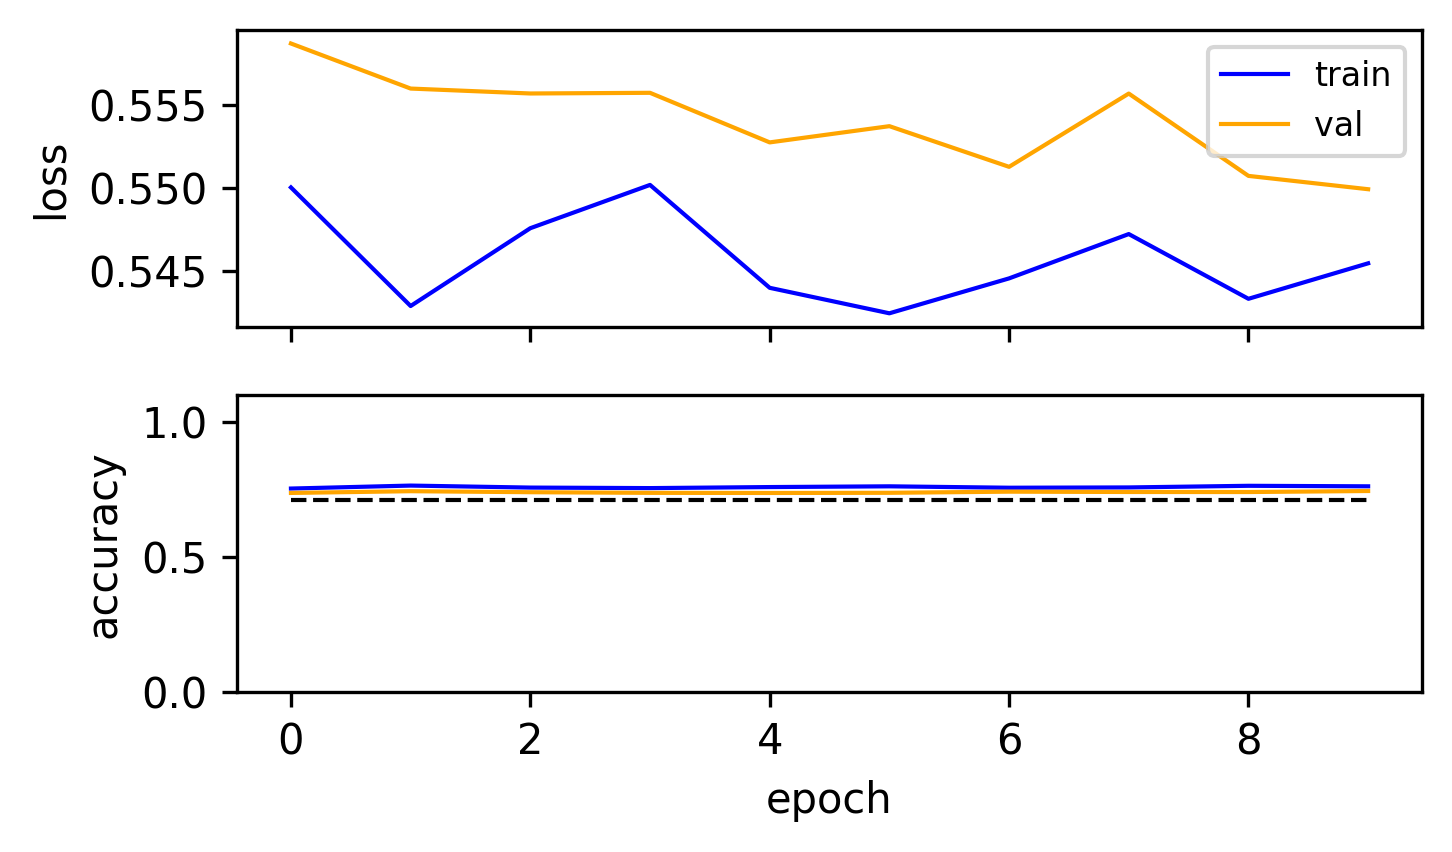

In [40]:
plot_accuracy_and_loss(results['scores'], baseline=df.gfa.mean())

# Let's put it all together!
0. set a random state
1. get our data ready for torch
    - what's the validation fraction?
    - do we want to use all our data or are we debugging w/ a small amount?
    - how big are our batches?
2. specify our model architecture
    - how many hidden layers?
    - how many neurons in each hidden layer?
    - what kind of activation functions?
    - what kind of normalization?
    - any dropout?
3. specify our loss function
4. specify our optimizer
    - what's the method?
    - what's the learning rate?
    - any regularization?
5. train the model
    - how many epochs?
6. visualize the results

In [41]:
def do_it_all(X_train, y_train, val_size=0.1, random_n=10, batch_size=8,
              hidden_layer_sizes=[256], output_size=3, act_fn=torch.nn.LeakyReLU(), dropout=0.1, norm='batch',
              loss_fn=torch.nn.CrossEntropyLoss(),
              learning_rate=1e-4, l2_penalty=1e-6,
              num_epochs=100, metric='accuracy', verbose=0,
              problem='classification', baseline=0,
              seed=44
             ):
    """
    Args:
        0. Random seeding:
            seed (int) : random seed

        1. Data loading:
            X_train (2d np array) : feature matrix
            y_train (1d np array) : target array
            val_size (float) : fraction of training to reserve for validation
            random_n (int) :
                - if random_n = 100, use only every 100th training point (for debugging)
                - set random_n = 1 to use all of your data
            batch_size (int) : number of training points to use for each parameter update step

        2. Model construction:
            hidden_layer_sizes (list) : list of neurons in each hidden layer
                - [256] would be one hidden layer with 256 neurons
                - [256, 128] would be a hidden layer with 256 neurons followed by a hidden layer with 128 neurons
            output_size (int) : number of classes in classification problem or 1 for regression problem
            act_fn (torch.nn.Module) : activation function after each linear hidden layer
            dropout (float or None) : if None, all hidden layers are fully connected, else dropout fraction of connections are dropped
            norm (str or None): if None, no normalization, else use norm to normalize before each layer

        3. Loss function:
            loss_fn (torch.nn.Module) : loss function for training

        4. Optimizer:
            learning_rate (float) : learning rate for parameter updates
            l2_penalty (float) : magnitude of L2 regularization

        5. Training:
            num_epochs (int) : how many epochs to train for
            metric (str) : what to "score" in addition to loss
            verbose (int) : how much to print

        6. Visualization:
            baseline (float) : value to plot a horizontal line on as sa baseline for comparison
            problem (str) : 'classification' or 'regression'

    Returns:
        dictionary with trained model and scores
    """

    print('\nusing %i (%.2f) data points' % (len(y_train)/random_n, 1/random_n))
    torch.manual_seed(seed)

    data_loader = load_data(X_train, y_train, val_size=val_size, random_n=random_n, batch_size=batch_size)

    model = construct_model(X_train, hidden_layer_sizes, output_size, act_fn, dropout, norm)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_penalty)

    results = train_epochs(num_epochs, data_loader, model, loss_fn, optimizer, metric=metric, verbose=verbose)

    plot_accuracy_and_loss(results['scores'], baseline=baseline, problem=problem)

    return results

## Let's see how we do w/ default parameters


using 454 (0.10) data points
Sequential(
  (norm1): BatchNorm1d(103, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=103, out_features=256, bias=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (drop1): Dropout1d(p=0.1, inplace=False)
  (fc_last): Linear(in_features=256, out_features=3, bias=True)
  (soft): Softmax(dim=None)
)

best scores:

  training = 0.81
  validation = 0.76


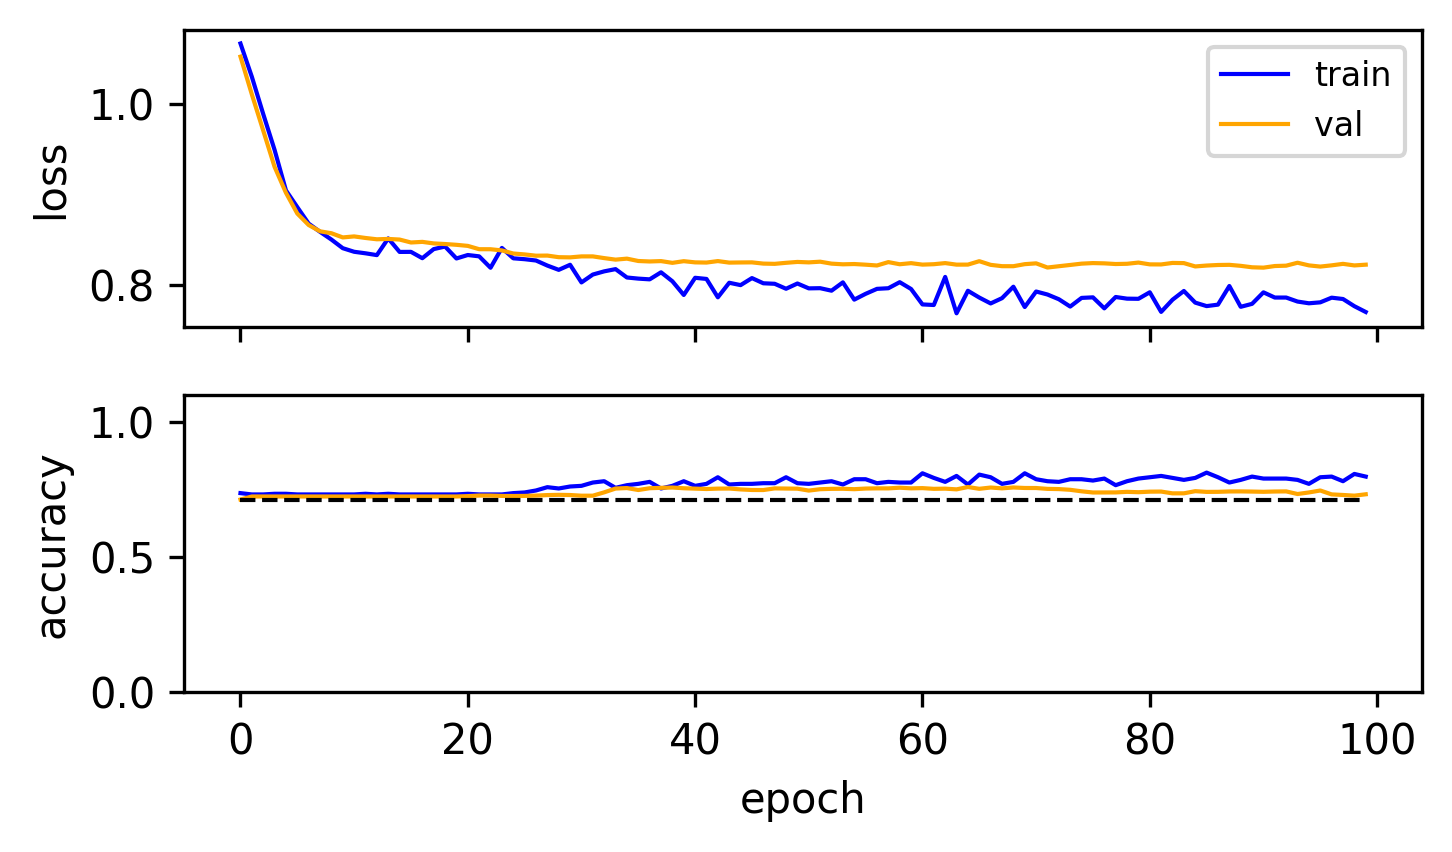

In [42]:
results = do_it_all(X_train, y_train, baseline=df.gfa.mean())

# **Hands-on**: Play with the inputs!

## Guidelines:
- Overfit your model to a very small number of data points (e.g. 45)
- See how regularization and the choice of activation function affects your models?
- Who can get the best validation accuracy?
